### TFT PIPELINE

In [1]:
import torch
import numpy as np
from datetime import datetime
import os
from  lightning.pytorch import Trainer
from  lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from  lightning.pytorch.loggers import TensorBoardLogger
import sys
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/')

from backend.ml_pipe.data.dataModule.tft.dataModule import CareerDataModule
from backend.ml_pipe.models.tft.model import TFTModel
from  lightning.pytorch.loggers import CSVLogger
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer, TemporalFusionTransformer, QuantileLoss


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from backend.ml_pipe.data.database.mongodb import MongoDb
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

def load_and_filter_labels_from_mongodb(
    user="florianrunkel",
    password="ur04mathesis",
    db_name="Database",
    collection="timeseries_dataset",
    top_n_remove=5,
    show_plot=True
):
    # 1. Daten laden
    mongo_client = MongoDb(user=user, password=password, db_name=db_name)
    result = mongo_client.get_all(collection)
    raw_data = result.get('data', [])
    df = pd.DataFrame(raw_data)

    # 2. Label bereinigen
    df["label"] = pd.to_numeric(df["label"], errors="coerce")
    df = df[df["label"].notna()]
    df = df[df["label"] > 0]

    # 3. Häufigste Labels identifizieren
    top_labels = df["label"].value_counts().nlargest(5).index.tolist()
    print("Häufigste Labels (werden gefiltert):", top_labels)

    # 5. Plot (optional)
    if show_plot:
        plt.figure(figsize=(10, 6))
        plt.hist(df["label"], bins=50)
        plt.title("Verteilung der Labels (gefiltert)")
        plt.xlabel("label (Tage)")
        plt.ylabel("Anzahl")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # 6. Zusammenfassung
    print(f"Datensätze nach Filterung: {len(df)}")
    print(f"Minimales Label: {df['label'].min()}")
    print(f"Maximales Label: {df['label'].max()}")
    print(f"Durchschnittliches Label: {df['label'].mean():.2f}")

    return df

In [3]:
from lightning.pytorch.callbacks import Callback

class PrintLossCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        loss = trainer.callback_metrics.get("train_loss")
        if loss is not None:
            print(f"Train Loss (Epoch {trainer.current_epoch}): {loss:.4f}")

    def on_validation_epoch_end(self, trainer, pl_module):
        loss = trainer.callback_metrics.get("val_loss")
        if loss is not None:
            print(f"Val Loss (Epoch {trainer.current_epoch}): {loss:.4f}")


Starte Karriere-Vorhersage Pipeline...
Lade Daten aus MongoDB...
Häufigste Labels (werden gefiltert): [46, 16, 92, 31, 183]


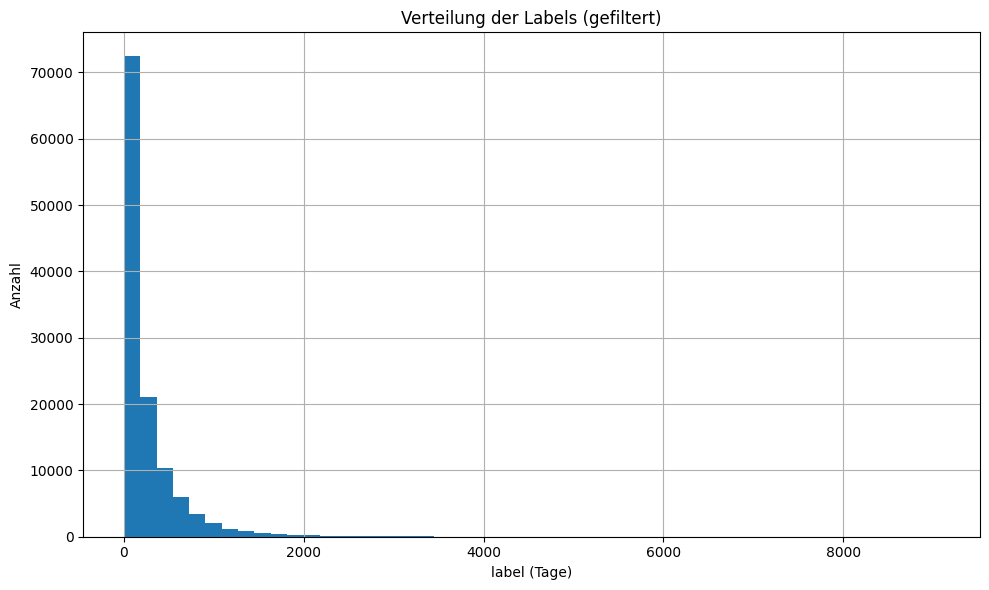

Datensätze nach Filterung: 119552
Minimales Label: 3
Maximales Label: 9065
Durchschnittliches Label: 264.80
DataFrame Shape: (119552, 17)
DataFrame Columns: ['_id', 'profile_id', 'aktuelle_position', 'zeitpunkt', 'label', 'berufserfahrung_bis_zeitpunkt', 'anzahl_wechsel_bisher', 'anzahl_jobs_bisher', 'durchschnittsdauer_bisheriger_jobs', 'highest_degree', 'age_category', 'anzahl_standortwechsel', 'study_field', 'company_name', 'company_industry', 'company_location', 'company_size_category']
Erste Zeile:
_id                                    683f04c78b7b61a57df733d0
profile_id                            zorikto-ochirov-63547a143
aktuelle_position                            Software Developer
zeitpunkt                                          1640300400.0
label                                                      1257
berufserfahrung_bis_zeitpunkt                              2337
anzahl_wechsel_bisher                                         3
anzahl_jobs_bisher                         

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_forecasting/data/timeseries.py:1831: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 282 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__profile_id': 12}, {'__group_id__profile_id': 15}, {'__group_id__profile_id': 17}, {'__group_id__profile_id': 20}, {'__group_id__profile_id': 25}, {'__group_id__profile_id': 28}, {'__group_id__profile_id': 31}, {'__group_id__profile_id': 32}, {'__group_id__profile_id': 55}, {'__group_id__profile_id': 59}]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_forecasting/data/encoders.py:400: UserWarning: Found 2867 unknown classes which were set to NaN
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

Training: 81466 Kandidaten
Validation: 38086 Kandidaten

DEBUG - Training Daten:
   profile_id  time_idx  target         position  feature_0  feature_1  \
0           0         0   168.0  Working Student      981.0        1.0   
1           0         1   168.0  Working Student     1019.0        1.0   
2           0         2   168.0  Working Student     1057.0        1.0   
3           0         3   168.0  Working Student     1080.0        1.0   
4           0         4   168.0           Intern     1157.0        2.0   

   feature_2  feature_3  feature_4  feature_5  ...    feature_14  feature_15  \
0        2.0      700.0        3.0        2.0  ...  8.660254e-01   -0.500000   
1        2.0      700.0        3.0        2.0  ...  5.000000e-01   -0.866025   
2        2.0      700.0        3.0        2.0  ...  1.224647e-16   -1.000000   
3        2.0      700.0        3.0        2.0  ... -5.000000e-01   -0.866025   
4        3.0      426.5        3.0        2.0  ... -8.660254e-01    0.5000

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 499.3k
Starte Training...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/tft/checkpoints exists and is not empty.

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 380 K  | train
3  | prescalers                         | ModuleDic

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 1337/1337 [01:10<00:00, 18.84it/s, v_num=14, train_loss_step=52.80, val_loss=57.20, train_loss_epoch=62.70]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1337/1337 [01:12<00:00, 18.56it/s, v_num=14, train_loss_step=52.80, val_loss=57.20, train_loss_epoch=62.70]
Bestes Modell: /Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/tft/checkpoints/tft-best-epoch=00-val_loss=57.24.ckpt


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
import torch
from datetime import datetime
from  lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from  lightning.pytorch.loggers import TensorBoardLogger
import  lightning.pytorch as pl
import os
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.metrics import MAE, RMSE

def run_pipeline():
    print("Starte Karriere-Vorhersage Pipeline...")

    # 1. Daten laden
    print("Lade Daten aus MongoDB...")
    df = load_and_filter_labels_from_mongodb()
    
    # Debug: Zeige DataFrame-Info
    print(f"DataFrame Shape: {df.shape}")
    print(f"DataFrame Columns: {df.columns.tolist()}")
    print(f"Erste Zeile:")
    print(df.iloc[0])

    datamodule = CareerDataModule(df)
    datamodule.setup()
    print(f"Training: {len(datamodule.training)} Kandidaten")
    print(f"Validation: {len(datamodule.validation)} Kandidaten")
    
    # Debug: Zeige Training-Daten
    print("\nDEBUG - Training Daten:")
    print(datamodule.training.head())
    print(f"Feature-Spalten: {[col for col in datamodule.training.columns if col.startswith('feature_')]}")
    
    # Debug: Prüfe Feature-Werte
    feature_cols = [col for col in datamodule.training.columns if col.startswith('feature_')]
    if feature_cols:
        print(f"\nDEBUG - Feature-Statistiken:")
        for col in feature_cols[:5]:  # Erste 5 Features
            print(f"{col}: min={datamodule.training[col].min()}, max={datamodule.training[col].max()}, mean={datamodule.training[col].mean():.2f}")
    
    # Debug: Prüfe ob alle Features 0 sind
    all_features_zero = True
    for col in feature_cols:
        if datamodule.training[col].sum() > 0:
            all_features_zero = False
            break
    
    if all_features_zero:
        print("\nWARNUNG: Alle Features sind 0! Das ist ein Problem!")
        return None, None
    else:
        print("\nFeatures sind nicht alle 0 - das ist gut!")
    
    # 3. Modell initialisieren
    print("Initialisiere TFT Modell...")
    model = TemporalFusionTransformer.from_dataset(
        datamodule.training_dataset,
        learning_rate=0.01,
        hidden_size=32,
        attention_head_size=4,  # Etwas mehr Fokus pro Head
        dropout=0.1,
        hidden_continuous_size=16,
        output_size=7,  # Für p10, p20 ... p90
        loss=QuantileLoss(),
        log_interval=10,
        reduce_on_plateau_patience=4,
    )
    print(f"Number of parameters in network: {model.size()/1e3:.1f}k")

    lr_logger = LearningRateMonitor()

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints",
        filename="tft-best-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        mode="min",
    )
    
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=10,
        mode="min"
    )

    logger = TensorBoardLogger(save_dir="logs")

    trainer = Trainer(
        max_epochs=1,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        gradient_clip_val=0.1,
        log_every_n_steps=10,
        enable_checkpointing=True,
        callbacks=[lr_logger, checkpoint_callback, early_stopping, PrintLossCallback()],
        logger=logger,
        deterministic=True,  # ✅ Für Reproduzierbarkeit
    )

    # 5. Training starten
    print("Starte Training...")
    trainer.fit(
        model,
        train_dataloaders=datamodule.train_dataloader(),
        val_dataloaders=datamodule.val_dataloader(),
    )

    # 6. Bestes Modell laden
    best_model_path = checkpoint_callback.best_model_path
    print(f"Bestes Modell: {best_model_path}")

    best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    # Evaluation auf Validierungsdaten
    val_dataloader = datamodule.val_dataloader()
    
    # Vorhersagen und tatsächliche Werte sammeln
    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_model.predict(val_dataloader)
    #print(predictions)

    # Alle Tensoren auf dasselbe Gerät bringen
    actuals = actuals.to(predictions.device)

    # Metriken initialisieren
    from pytorch_forecasting.metrics import MAE, RMSE
    mae_metric = MAE().to(predictions.device)
    rmse_metric = RMSE().to(predictions.device)

    # Metriken berechnen
    mae = mae_metric(predictions, actuals)
    rmse = rmse_metric(predictions, actuals)

    print("\nModell-Evaluation auf Validierungsdaten:")
    print(f"MAE: {mae:.2f} Tage")
    print(f"RMSE: {rmse:.2f} Tage")
    
    print("Speichere Modell...")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = f"./saved_models/tft_{timestamp}.ckpt"
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    trainer.save_checkpoint(model_path)
    print(f"Modell gespeichert unter: {model_path}")
    return best_model, trainer

# Pipeline ausführen
best_model, trainer = run_pipeline()
#[I 2025-05-20 16:25:48,382] Trial 0 finished with value: 137.7418975830078 and parameters: {'gradient_clip_val': 0.7663094383604092, 'hidden_size': 63, 'dropout': 0.27868811302673885, 'hidden_continuous_size': 9, 'attention_head_size': 3, 'learning_rate': 0.011199776102729224}. Best is trial 0 with value: 137.7418975830078.


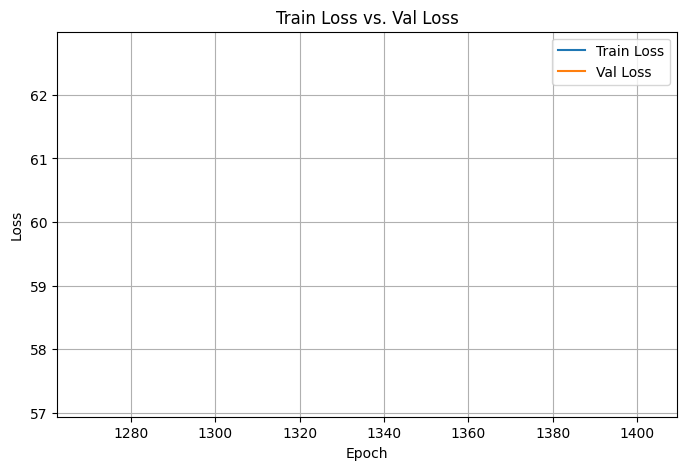

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# EventAccumulator initialisieren und laden
ea = event_accumulator.EventAccumulator(trainer.logger.log_dir)
ea.Reload()

# Die richtigen Keys für die Losses
val_loss = ea.Scalars('val_loss')
train_loss = ea.Scalars('train_loss_epoch')

# Plot
plt.figure(figsize=(8,5))
plt.plot([x.step for x in train_loss], [x.value for x in train_loss], label='Train Loss')
plt.plot([x.step for x in val_loss], [x.value for x in val_loss], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs. Val Loss')
plt.legend()
plt.grid(True)
plt.show()

hp_metric
lr-Adam
train_loss_step
epoch
val_loss
val_SMAPE
val_MAE
val_RMSE
val_MAPE
train_loss_epoch


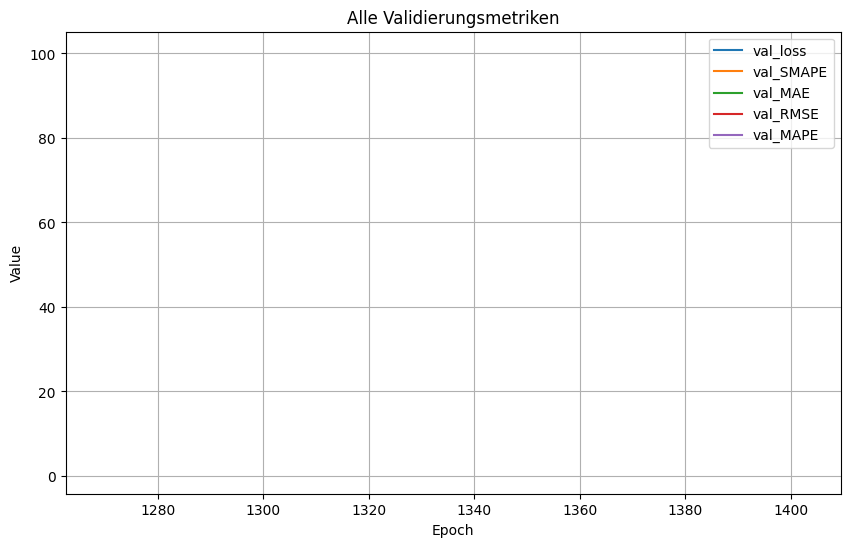

In [ ]:
from tensorboard.backend.event_processing import event_accumulator

ea = event_accumulator.EventAccumulator(trainer.logger.log_dir)
ea.Reload()

for key in ea.Tags()['scalars']:
    print(key)

val_keys = [k for k in ea.Tags()['scalars'] if k.startswith('val_')]
plt.figure(figsize=(10,6))
for key in val_keys:
    values = ea.Scalars(key)
    plt.plot([x.step for x in values], [x.value for x in values], label=key)
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Alle Validierungsmetriken')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/hw/wbg7dg7934z5jd1dv8g7rxjc0000gn/T/ipykernel_64029/4198391562.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_dataset = torch.load(


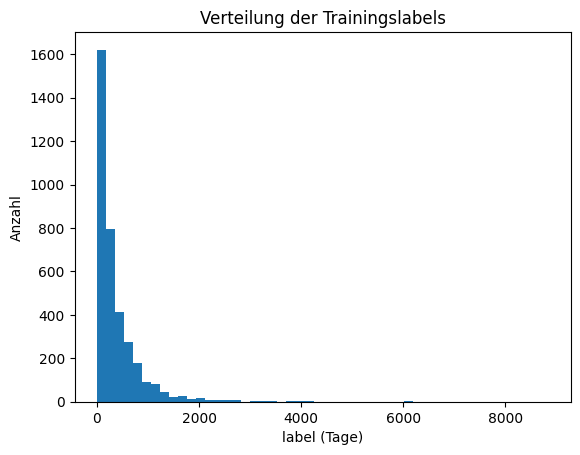

add 2 Dummy-Zeitpunkte angehängt. Neue Länge: 6
  profile_id  zeitpunkt   label  berufserfahrung_bis_zeitpunkt  \
0   new_user 2015-10-01   762.0                            0.0   
1   new_user 2017-11-01  1703.0                          762.0   
2   new_user 2022-08-01   122.0                         2465.0   
3   new_user 2023-03-01   849.0                         2587.0   
4   new_user 2023-03-31   849.0                         2587.0   
5   new_user 2023-04-30   849.0                         2587.0   

   anzahl_wechsel_bisher  anzahl_jobs_bisher  \
0                      0                   1   
1                      1                   2   
2                      2                   3   
3                      3                   4   
4                      3                   4   
5                      3                   4   

   durchschnittsdauer_bisheriger_jobs                   mapped_position  \
0                          762.000000              senior data engineer   
1 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_forecasting/data/timeseries.py:1693: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_forecasting/data/encoders.py:400: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/tft/saved_models/tft_20250522_165442.ckpt'

In [ ]:
import sys
import json
import pandas as pd
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/')

from rapidfuzz import process, fuzz

# LinkedIn Profildaten als Raw-String (beachte das 'r' vor dem String)
linkedin_data_str = r'''{"skills":["Multitasking","Kundenservice","Interpersonelle Fähigkeiten","Kaltakquise","Hubspot CRM","Customer-Relationship-Management (CRM)"],"firstName":"Darya","lastName":"Chernuska","profilePicture":"https://media.licdn.com/dms/image/v2/D4E03AQE0yuZ6cg8f4A/profile-displayphoto-shrink_100_100/profile-displayphoto-shrink_100_100/0/1670856025914?e=1749686400&v=beta&t=jI1mkiVnkD7teWPncsg8QtKAwZKB-az53_4ny7C7XvI","linkedinProfile":"https://www.linkedin.com/in/daryachernuska","education":[{"duration":"01/01/2017 - 01/01/2022","institution":"Ludwig-Maximilians-Universität München","endDate":"01/01/2022","degree":"","startDate":"01/01/2017"}],"providerId":"ACoAAD0rz_IBI0XfqqBDUscwHoFwuOqJa_c5T2I","workExperience":[{"duration":"01/03/2023 - Present","endDate":"Present","companyInformation":{"employee_count":515,"activities":["Telefonie","Internet","Vernetzung","Rechenzentrum","Glasfaser","Highspeed-Internet","Business-Internet","SIP-Trunk","Cloud-Lösungen","Connect-Cloud","Connect-LAN","Premium IP","Internet + Telefonie","Lösungen für Geschäftskunden"],"name":"M-net Telekommunikations GmbH","description":"Als regionaler Telekommunikationsanbieter versorgt M-net große Teile Bayerns, den Großraum Ulm sowie weite Teile des hessischen Landkreises Main-Kinzig mit zukunftssicherer Kommunikationstechnologie.","industry":["Telecommunications"]},"description":"","company":"M-net Telekommunikations GmbH","location":"München, Bayern, Deutschland · Hybrid","position":"Disponentin","startDate":"01/03/2023"},{"duration":"01/08/2022 - 01/12/2022","endDate":"01/12/2022","companyInformation":{"employee_count":2048,"activities":["HR Software","HR Management","Recruitung","Employee Management","Applicant Tracking System","Employee Selfservice","Time-Off Management","Cloud Software","Onboarding and Offboarding","HR Reporting","Performance Management","Payroll","HR","HR Tech","Human Resources"],"name":"Personio","description":"Personio's Intelligent HR Platform helps small and medium-sized organizations unlock the power of people by making complicated, time-consuming tasks simple and efficient.","industry":["Software Development"]},"description":"","company":"Personio","location":"München, Bayern, Deutschland","position":"Sales Development Representative","startDate":"01/08/2022"},{"duration":"01/11/2017 - 01/07/2022","endDate":"01/07/2022","companyInformation":{"employee_count":662,"activities":["Scandinavian design","Furniture","Design","Product design","Retail","Web","Steelcase partner","Wholesale","B2B","Contract sales","Online","Digital","Creativity"],"name":"BOLIA","description":"Our collection is inspired by the vivid Scandinavian nature","industry":["Retail Furniture and Home Furnishings"]},"description":"","company":"Bolia.com","location":"München, Bayern, Deutschland","position":"Sales Consultant","startDate":"01/11/2017"},{"duration":"01/10/2015 - 01/11/2017","endDate":"01/11/2017","companyInformation":{},"description":"","company":"Pepperminds","location":"München, Bayern, Deutschland","position":"Senior Team Lead","startDate":"01/10/2015"}],"location":"Munich, Bavaria, Germany","certifications":[],"headline":"-","languageSkills":{}}'''
linkedin_data = json.loads(linkedin_data_str)

from datetime import datetime

with open("/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/data/featureEngineering/position_level.json", "r") as f:
    position_entries = json.load(f)

position_map = {
    entry["position"].lower(): (
        entry["level"], 
        entry["branche"],
        entry.get("durchschnittszeit_tage", 365)
    ) for entry in position_entries
}
all_positions = list(position_map.keys())

def get_branche_num(branche):
    branche_map = {"sales": 1, "engineering": 2, "consulting": 3}
    return branche_map.get(branche, 0)

def map_position_fuzzy(pos, threshold=30):
    pos_clean = pos.lower().strip()
    if pos_clean in position_map:
        level, branche, durchschnittszeit = position_map[pos_clean]
        match = pos_clean
        score = 100  # Maximale Ähnlichkeit, da exakter Treffer
    else:
        match, score, _ = process.extractOne(pos_clean, all_positions, scorer=fuzz.ratio)
        if score >= threshold:
            level, branche, durchschnittszeit = position_map[match]
        else:
            return (None, None, None, None)
    return (match, float(level), float(get_branche_num(branche)), float(durchschnittszeit))

def append_dummy_rows(df, missing_count):

    df = df.copy()
    last_row = df.iloc[-1].copy()

    for i in range(missing_count):
        new_row = last_row.copy()
        new_row["time_idx"] = df["time_idx"].max() + 1
        new_row["zeitpunkt"] = df["zeitpunkt"].max() + pd.Timedelta(days=30)
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    return df

def check_min_timesteps(df, encoder_length=4, prediction_length=2):

    required = encoder_length + prediction_length
    actual = len(df)

    if actual >= required:
        return True, 0
    else:
        return False, required - actual

def extract_features_from_linkedin(data):
    rows = []

    total_experience = 0
    job_durations = []
    
    # Sortiere die Jobs nach Startdatum (älteste zuerst)
    sorted_jobs = sorted(data["workExperience"], 
                        key=lambda x: datetime.strptime(x["startDate"], "%d/%m/%Y"))
    
    for i, job in enumerate(sorted_jobs):
        start_date = datetime.strptime(job["startDate"], "%d/%m/%Y")
        end_date = datetime.today() if job["endDate"] == "Present" else datetime.strptime(job["endDate"], "%d/%m/%Y")
        
        duration = end_date - start_date  # ➜ timedelta
        duration_days = duration.days     # ➜ int
        
        if i > 0:
            # Addiere die Dauer des vorherigen Jobs zur Gesamterfahrung
            prev_job = sorted_jobs[i-1]
            prev_start = datetime.strptime(prev_job["startDate"], "%d/%m/%Y")
            prev_end = datetime.today() if prev_job["endDate"] == "Present" else datetime.strptime(prev_job["endDate"], "%d/%m/%Y")
            total_experience += (prev_end - prev_start).days
        
        # Berechne die durchschnittliche Dauer der bisherigen Jobs
        job_durations.append(duration_days)
        avg_duration = sum(job_durations) / len(job_durations) if job_durations else 0


        mapped_position, level, branche, durchschnittszeit = map_position_fuzzy(job["position"])

        row = {
            "profile_id": "new_user",
            "zeitpunkt": start_date,
            "label": float(duration_days),
            "berufserfahrung_bis_zeitpunkt": float(total_experience),
            "anzahl_wechsel_bisher": i,
            "anzahl_jobs_bisher": i + 1,
            "durchschnittsdauer_bisheriger_jobs": float(avg_duration),
            "mapped_position": mapped_position, 
            "level":level,
            "branche":branche,
            "durchschnittszeit": durchschnittszeit
        }
        rows.append(row)

    df = pd.DataFrame(rows)
    df["zeitpunkt"] = pd.to_datetime(df["zeitpunkt"])
    df = df.sort_values("zeitpunkt")
    df["time_idx"] = range(1, len(df) + 1)
    return df

df_new = extract_features_from_linkedin(linkedin_data)
#print(df_new)

training_dataset = torch.load(
    "/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/tft/training_dataset.pt"
)
import matplotlib.pyplot as plt

plt.hist(training_dataset.data["target"], bins=50)
plt.title("Verteilung der Trainingslabels")
plt.xlabel("label (Tage)")
plt.ylabel("Anzahl")
plt.show()


is_valid, missing = check_min_timesteps(df_new, encoder_length=4, prediction_length=2)

if not is_valid:
    df_new = append_dummy_rows(df_new, missing)
    print(f"add {missing} Dummy-Zeitpunkte angehängt. Neue Länge: {len(df_new)}")

print(df_new)
# Verwende die Struktur des originalen Trainings-Datasets
new_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset,
    df_new,
    predict=True,   
    allow_missing_timesteps=True,
    min_encoder_length=4,   # 👈 GANZ WICHTIG!
    min_prediction_idx=1 
)


# Dataloader für Vorhersage
new_dataloader = new_dataset.to_dataloader(train=False, batch_size=1)

tft = TemporalFusionTransformer.load_from_checkpoint(
    "/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/tft/saved_models/tft_20250522_165442.ckpt"
)

prediction = tft.predict(new_dataloader, mode="prediction")
print(prediction)


In [7]:
import json
import sys
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/')

linkedin_data = {"skills":["Multitasking","Kundenservice","Interpersonelle Fähigkeiten","Kaltakquise","Hubspot CRM","Customer-Relationship-Management (CRM)"],"firstName":"Darya","lastName":"Chernuska","profilePicture":"https://media.licdn.com/dms/image/v2/D4E03AQE0yuZ6cg8f4A/profile-displayphoto-shrink_100_100/profile-displayphoto-shrink_100_100/0/1670856025914?e=1749686400&v=beta&t=jI1mkiVnkD7teWPncsg8QtKAwZKB-az53_4ny7C7XvI","linkedinProfile":"https://www.linkedin.com/in/daryachernuska","education":[{"duration":"01/01/2017 - 01/01/2022","institution":"Ludwig-Maximilians-Universität München","endDate":"01/01/2022","degree":"","startDate":"01/01/2017"}],"providerId":"ACoAAD0rz_IBI0XfqqBDUscwHoFwuOqJa_c5T2I","workExperience":[{"duration":"01/03/2023 - Present","endDate":"Present","companyInformation":{"employee_count":515,"activities":["Telefonie","Internet","Vernetzung","Rechenzentrum","Glasfaser","Highspeed-Internet","Business-Internet","SIP-Trunk","Cloud-Lösungen","Connect-Cloud","Connect-LAN","Premium IP","Internet + Telefonie","Lösungen für Geschäftskunden"],"name":"M-net Telekommunikations GmbH","description":"Als regionaler Telekommunikationsanbieter versorgt M-net große Teile Bayerns, den Großraum Ulm sowie weite Teile des hessischen Landkreises Main-Kinzig mit zukunftssicherer Kommunikationstechnologie.","industry":["Telecommunications"]},"description":"","company":"M-net Telekommunikations GmbH","location":"München, Bayern, Deutschland · Hybrid","position":"Disponentin","startDate":"01/03/2023"},{"duration":"01/08/2022 - 01/12/2022","endDate":"01/12/2022","companyInformation":{"employee_count":2048,"activities":["HR Software","HR Management","Recruitung","Employee Management","Applicant Tracking System","Employee Selfservice","Time-Off Management","Cloud Software","Onboarding and Offboarding","HR Reporting","Performance Management","Payroll","HR","HR Tech","Human Resources"],"name":"Personio","description":"Personio's Intelligent HR Platform helps small and medium-sized organizations unlock the power of people by making complicated, time-consuming tasks simple and efficient.","industry":["Software Development"]},"description":"","company":"Personio","location":"München, Bayern, Deutschland","position":"Sales Development Representative","startDate":"01/08/2022"},{"duration":"01/11/2017 - 01/07/2022","endDate":"01/07/2022","companyInformation":{"employee_count":662,"activities":["Scandinavian design","Furniture","Design","Product design","Retail","Web","Steelcase partner","Wholesale","B2B","Contract sales","Online","Digital","Creativity"],"name":"BOLIA","description":"Our collection is inspired by the vivid Scandinavian nature","industry":["Retail Furniture and Home Furnishings"]},"description":"","company":"Bolia.com","location":"München, Bayern, Deutschland","position":"Sales Consultant","startDate":"01/11/2017"},{"duration":"01/10/2015 - 01/11/2017","endDate":"01/11/2017","companyInformation":{},"description":"","company":"Pepperminds","location":"München, Bayern, Deutschland","position":"Senior Team Lead","startDate":"01/10/2015"}],"location":"Munich, Bavaria, Germany","certifications":[],"headline":"-","languageSkills":{}}

from backend.ml_pipe.models.tft.predict import predict
prediction = predict(linkedin_data)
print(prediction)

/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/tft/predict.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_dataset 

add 2 Dummy-Zeitpunkte angehängt. Neue Länge: 6
[[[0.0, 0.0, 0.0, 68.93547058105469, 120.22471618652344, 212.53469848632812, 462.974609375], [0.0, 0.0, 0.0, 0.0, 73.78724670410156, 118.57319641113281, 245.34689331054688]]]
68.93547058105469
[{'feature': 'Average Job Duration', 'impact_percentage': 27.994671424858264, 'description': 'Mean duration across all previous positions'}, {'feature': 'Career Progression Stage', 'impact_percentage': 20.001488896084734, 'description': 'Current phase in professional development'}, {'feature': 'Work Experience', 'impact_percentage': 17.40777490091355, 'description': 'Total professional experience accumulated over time'}, {'feature': 'Career Timeline Position', 'impact_percentage': 13.983179609314753, 'description': 'Position in overall career trajectory'}, {'feature': 'Historical Data Points', 'impact_percentage': 13.883870820677089, 'description': 'Number of career events analyzed'}, {'feature': 'Average Job Duration', 'impact_percentage': 2.965973

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
